# Lab Assignment 09: Recurrent Network Architectures


### Dataset Selection

Select a dataset identically to lab two. That is, the dataset must be text data (or time series sequence). In terms of generalization performance, it is helpful to have a large dataset of similar sized text documents. It is fine to perform binary classification or multi-class classification. The classification can be "many-to-one" or "many-to-many" sequence classification, whichever you feel more comfortable with. 

### Preparation (40 points total)
[20 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).   

[10 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

[10 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

### Modeling (50 points total)

[25 points] Investigate at least two different recurrent network architectures (perhaps LSTM and GRU). Adjust hyper-parameters of the networks as needed to improve generalization performance. 

[25 points] Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab. Visualize the best results of the RNNs.   

### Exceptional Work (10 points total)
You have free reign to provide additional analyses.

One idea: Use more than a single chain of LSTMs or GRUs (i.e., use multiple parallel chains). 

Another Idea: Try to create a RNN for generating novel text. 

In [1]:
import pandas as pd
import numpy as np
import os
from scipy.misc import imread
import matplotlib.pyplot as plt
import random
import warnings
from keras.datasets import reuters
from keras.preprocessing import sequence
from keras import utils


Using TensorFlow backend.


## Preprocessing

In [2]:
data = np.load('data/ourdata.npy')

In [3]:
data[0][1]


'When watching A Bug\'s Life for the first time in a long while, I couldn\'t help but see the comparisons with last year\'s Happy Feet. As far as the main storyline goes, they are very similar, an outcast doing what he can to fit in while also attempting to be special. It just goes to show you how much better that film could have been without its liberal diatribe conclusion. A lot of people disagree with me when I say that I really like Pixar\'s sophomore effort. Sure it doesn\'t manage to capture the splendor of Toy Story, nor is the animation out of this world. However, the story is top-notch and the characters are wonderful to spend time with. With plenty of laughs and a moral center to boot, I could watch this one just as much as the studio\'s other classics.<br /><br />There is a lot about finding strength from within to conquer all odds here. Between our lead Flick needing to keep his self-esteem up to save his colony, the colony needing to open their eyes onto a new way of livin

In [4]:
# create data set and labels
X = data.flatten()
pos = np.full((25000,), 1)
neg = np.full((25000,), 0)
y = np.concatenate((pos, neg), axis=0)


In [5]:
%%time
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = None
MAX_ART_LEN = 1000 # maximum and minimum number of words

tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y_ohe = keras.utils.to_categorical(y)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Found 124252 unique tokens. Distilled to 124252 top words.
Shape of data tensor: (50000, 1000)
Shape of label tensor: (50000, 2)
124252
CPU times: user 29.3 s, sys: 440 ms, total: 29.7 s
Wall time: 29.7 s


In [10]:
from sklearn.model_selection import train_test_split
# Split it into train / test subsets
X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X, y_ohe, test_size=0.2,
                                                            stratify=y, 
                                                            random_state=42)
NUM_CLASSES = 2
print(X_train.shape,y_train_ohe.shape)
print(np.sum(y_train_ohe,axis=0))

(40000, 1000) (40000, 2)
[ 20000.  20000.]


In [66]:
%%time
EMBED_SIZE = 100
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('data/glove.6B.100d.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

corpus length: 600893
total chars: 57
nb sequences: 200285
Vectorization...
Build model...

--------------------------------------------------
Iteration 1
Epoch 1/1


KeyboardInterrupt: 

In [12]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_ART_LEN,
                            trainable=False)

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

rnn = Sequential()
rnn.add(embedding_layer)
rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
print(rnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 100)         12425300  
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 202       
Total params: 12,505,902
Trainable params: 80,602
Non-trainable params: 12,425,300
_________________________________________________________________
None


In [ ]:
rnn.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=3, batch_size=64)

Train on 40000 samples, validate on 10000 samples
Epoch 1/3
 3968/40000 [=>............................] - ETA: 2120s - loss: 0.6736 - acc: 0.5754

## old code below

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

rnn = Sequential()
rnn.add(embedding_layer)
rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
print(rnn.summary())

In [13]:
from keras.models import Sequential, Input, Model
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras.layers.embeddings import Embedding

EMBED_SIZE = 50
rnns = []
input_holder = Input(shape=(X.shape[1], ))
shared_embed = Embedding(top_words, 
                EMBED_SIZE, 
                input_length=MAX_ART_LEN)(input_holder)

for func in [SimpleRNN, LSTM, GRU]:
    
    x = func(50,dropout=0.2, recurrent_dropout=0.2)(shared_embed)
    x = Dense(NUM_CLASSES, activation='sigmoid')(x)
    rnn=Model(inputs=input_holder,outputs=x)
    rnn.compile(loss='categorical_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    print(rnn.summary())
    rnns.append(rnn)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 1000, 50)          6212600   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 50)                5050      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102       
Total params: 6,217,752
Trainable params: 6,217,752
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1000)              0         
_____________________________________________________________

In [19]:
for rnn, name in zip(rnns,['lstm','gru']):
    print('Round 2 training,',name,'========')
    rnn.fit(X_train, y_train_ohe, epochs=3, batch_size=64, validation_data=(X_test, y_test_ohe))

Round 2 training, lstm ========
Train on 40000 samples, validate on 10000 samples
Epoch 1/3
17728/40000 [============>.................] - ETA: 104s - loss: 0.6698 - acc: 0.5838

InvalidArgumentError: indices[19,934] = 124252 is not in [0, 124252)
	 [[Node: embedding_3/Gather = Gather[Tindices=DT_INT32, Tparams=DT_FLOAT, validate_indices=true, _device="/job:localhost/replica:0/task:0/cpu:0"](embedding_3/embeddings/read, embedding_3/Cast)]]

Caused by op 'embedding_3/Gather', defined at:
  File "/usr/local/es7/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/es7/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/users5/me/danhn/ML/lab8/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/users5/me/danhn/ML/lab8/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/users5/me/danhn/ML/lab8/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/users5/me/danhn/ML/lab8/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/users5/me/danhn/ML/lab8/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/users5/me/danhn/ML/lab8/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/users5/me/danhn/ML/lab8/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/users5/me/danhn/ML/lab8/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/users5/me/danhn/ML/lab8/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/users5/me/danhn/ML/lab8/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/users5/me/danhn/ML/lab8/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/users5/me/danhn/ML/lab8/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/users5/me/danhn/ML/lab8/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/users5/me/danhn/ML/lab8/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/users5/me/danhn/ML/lab8/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/users5/me/danhn/ML/lab8/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2683, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/users5/me/danhn/ML/lab8/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2787, in run_ast_nodes
    if self.run_code(code, result):
  File "/users5/me/danhn/ML/lab8/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2847, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-f46ad4d0ca6c>", line 11, in <module>
    input_length=MAX_ART_LEN)(input_holder)
  File "/users5/me/danhn/ML/lab8/lib/python3.5/site-packages/keras/engine/topology.py", line 578, in __call__
    output = self.call(inputs, **kwargs)
  File "/users5/me/danhn/ML/lab8/lib/python3.5/site-packages/keras/layers/embeddings.py", line 120, in call
    out = K.gather(self.embeddings, inputs)
  File "/users5/me/danhn/ML/lab8/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 968, in gather
    return tf.gather(reference, indices)
  File "/usr/local/es7/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1359, in gather
    validate_indices=validate_indices, name=name)
  File "/usr/local/es7/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/usr/local/es7/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/es7/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): indices[19,934] = 124252 is not in [0, 124252)
	 [[Node: embedding_3/Gather = Gather[Tindices=DT_INT32, Tparams=DT_FLOAT, validate_indices=true, _device="/job:localhost/replica:0/task:0/cpu:0"](embedding_3/embeddings/read, embedding_3/Cast)]]


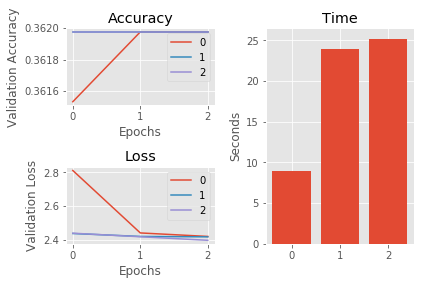

In [61]:
modes = [0, 1, 2]
plt.style.use('ggplot')
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax1.set_title('Accuracy')
ax1.set_ylabel('Validation Accuracy')
ax1.set_xlabel('Epochs')
ax2 = plt.subplot2grid((2, 2), (1, 0))
ax2.set_title('Loss')
ax2.set_ylabel('Validation Loss')
ax2.set_xlabel('Epochs')
ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
ax3.set_title('Time')
ax3.set_ylabel('Seconds')
for mode, result in zip(modes, results):
    ax1.plot(result[0].epoch, result[0].history['val_acc'], label=mode)
    ax2.plot(result[0].epoch, result[0].history['val_loss'], label=mode)
ax1.legend()
ax2.legend()
ax3.bar(np.arange(len(results)), [x[1] for x in results],
        tick_label=modes, align='center')
plt.tight_layout()
plt.show()

In [62]:
path = get_file('nietzsche.txt', origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path).read().lower()
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))

corpus length: 600893
total chars: 57


In [67]:
data = np.load('data/ourdata.npy')
text = ' '.join(data[0])
len(text)

33144941

In [72]:
data1 = text[:10000]
len(data1)

10000